In [64]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomBrightness
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError
import albumentations as A

# Data Loading


In [49]:
cifar100_dataset, cifar100_info = tfds.load('cifar100', split='train', as_supervised=True, with_info=True)

In [ ]:
print(cifar100_info)

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpxsdtm9lptfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=F

# Data Preprocessing

## Data Splitting

In [101]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(DATASET_SIZE * TRAIN_RATIO))
  print(len(train_dataset))

  val_dataset = dataset.skip(int(DATASET_SIZE * TRAIN_RATIO)).take(int(DATASET_SIZE * VAL_RATIO))
  print(len(val_dataset))

  test_dataset = dataset.skip(int(DATASET_SIZE * (TRAIN_RATIO + VAL_RATIO)))
  print(len(test_dataset))

  return train_dataset, val_dataset, test_dataset

In [102]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(cifar100_dataset, TRAIN_RATIO, VAL_RATIO)
train_dataset

40000
5000
5000


<_TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Dataset Visualization

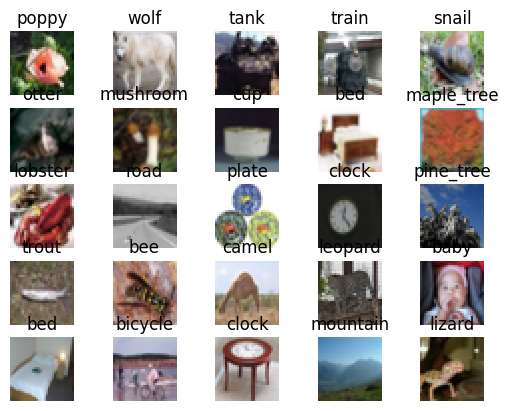

In [52]:
for i, (image, label) in enumerate(train_dataset.take(25)):
 ax = plt.subplot(5, 5, i + 1)
 plt.imshow(image)
 plt.title(cifar100_info.features['label'].int2str(label))
 ax.axis('off')

In [ ]:
labels = [cifar100_info.features['label'].int2str(i) for i in range(cifar100_info.features['label'].num_classes)]
print(labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

# Data Augmentation

## Resizing and Rescaling

In [103]:
IM_SIZE = 32
def resize_rescale(image, label):
    resized_image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    one_hot_label = tf.one_hot(label, depth=100)

    return resized_image, one_hot_label

## Augment Layers

In [104]:

augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501)),
    RandomFlip(mode = 'horizontal'),
    RandomCrop(32, 32),
    RandomBrightness(0.2),

])

## Batching and Mapping

In [105]:
BATCH_SIZE = 64
train_dataset = (train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE)
)

In [106]:
val_dataset = (val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE)
)

In [107]:
test_dataset = (test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True)
.map(resize_rescale)
.batch(BATCH_SIZE)
.prefetch(tf.data.AUTOTUNE)
)

# Model Creation

In [126]:

model = tf.keras.Sequential([
    # Input Layer
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    augment_layers,

    # first conv layer
    Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    MaxPool2D(pool_size = 2, strides= 2),

    # second conv layer
    Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    MaxPool2D(pool_size = 2, strides= 2),

    # second conv layer
    Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    MaxPool2D(pool_size = 2, strides= 2),

    Flatten(),

    # first dense layer
    Dense(256, activation = 'relu'),


    # second dense layer
    Dense(128, activation = 'relu'),

    # Output Layer
    Dense(100, activation = 'softmax') # 100 classes
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 128)       

In [131]:
model.compile(optimizer= Adam(0.001),
              loss = CategoricalCrossentropy(),
              metrics = 'accuracy'

)

In [132]:

history = model.fit(train_dataset, validation_data= val_dataset, epochs= 7, verbose = 1)

Epoch 1/7
625/625 [==============================] - 122s 192ms/step - loss: 4.6132 - accuracy: 0.0096 - val_loss: 4.6135 - val_accuracy: 0.0074
Epoch 2/7
625/625 [==============================] - 119s 191ms/step - loss: 4.6083 - accuracy: 0.0102 - val_loss: 4.6103 - val_accuracy: 0.0074
Epoch 3/7
625/625 [==============================] - 119s 191ms/step - loss: 4.6065 - accuracy: 0.0104 - val_loss: 4.6089 - val_accuracy: 0.0074
Epoch 4/7
625/625 [==============================] - 129s 206ms/step - loss: 4.6059 - accuracy: 0.0100 - val_loss: 4.6084 - val_accuracy: 0.0074
Epoch 5/7
625/625 [==============================] - 116s 185ms/step - loss: 4.6056 - accuracy: 0.0101 - val_loss: 4.6082 - val_accuracy: 0.0074
Epoch 6/7
625/625 [==============================] - 117s 187ms/step - loss: 4.6055 - accuracy: 0.0096 - val_loss: 4.6081 - val_accuracy: 0.0074
Epoch 7/7
625/625 [==============================] - 119s 191ms/step - loss: 4.6055 - accuracy: 0.0093 - val_loss: 4.6081 - val_ac

In [133]:
# finish thsi tomorrow
# better the model
# fine-tune it
# plot confusion matrix
# all metrics

# next dataset is Labeled Faces in the Wild(LFW) Dataset